In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.random as random

In [2]:
X = random.multivariate_normal(
    key=random.PRNGKey(0),
    shape=(100,),
    mean=jnp.array([1, 3]),
    cov=jnp.array([[1.0, -0.5], [-0.5, 2.0]]),
)

In [3]:
X.shape

(100, 2)

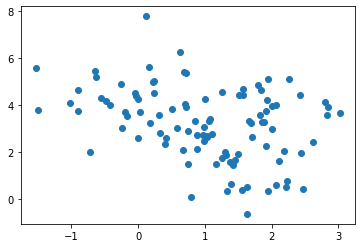

In [4]:
plt.scatter(X[:, 0], X[:, 1])

In [5]:
from flax import linen as nn
from typing import Any, Callable, Sequence


In [6]:
class Encoder(nn.Module):
    bottleneck: int
        
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.bottleneck)(x)
        return x

In [7]:
class Decoder(nn.Module): 
    out: int
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.out)(x)
        return x

In [8]:
enc = Encoder(bottleneck=1)

dec = Decoder(out=2)

In [9]:
params_enc = enc.init(random.PRNGKey(0), X)
X_bottlenecked = enc.apply(params_enc, X)
X_bottlenecked.shape

(100, 1)

In [10]:
print(enc.tabulate(random.PRNGKey(0), X))

print(dec.tabulate(random.PRNGKey(0), X_bottlenecked))


                               Encoder Summary                                
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs         ┃ outputs        ┃ params               ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Encoder │ float32[100,2] │ float32[100,1] │                      │
├─────────┼─────────┼────────────────┼────────────────┼──────────────────────┤
│ Dense_0 │ Dense   │ float32[100,2] │ float32[100,5] │ bias: float32[5]     │
│         │         │                │                │ kernel: float32[2,5] │
│         │         │                │                │                      │
│         │         │                │                │ 15 (60 B)            │
├─────────┼─────────┼────────────────┼────────────────┼──────────────────────┤
│ Dense_1 │ Dense   │ float32[100,5] │ float32[100,1] │ bias: float32[1]     │
│         │         │                │             

In [11]:
class AE(nn.Module):
    bottleneck: int
    out: int
    def setup(self):
        # Alternative to @nn.compact -> explicitly define modules
        # Better for later when we want to access the encoder and decoder explicitly
        self.encoder = Encoder(bottleneck=self.bottleneck)
        self.decoder = Decoder(out=self.out)

    def __call__(self, x):
        
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    

In [12]:
ae = AE(1, 2)

In [13]:
ae

AE(
    # attributes
    bottleneck = 1
    out = 2
)

In [14]:
print(ae.tabulate(random.PRNGKey(0), X))



                                   AE Summary                                   
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path            ┃ module  ┃ inputs         ┃ outputs        ┃ params         ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│                 │ AE      │ float32[100,2] │ float32[100,2] │                │
├─────────────────┼─────────┼────────────────┼────────────────┼────────────────┤
│ encoder         │ Encoder │ float32[100,2] │ float32[100,1] │                │
├─────────────────┼─────────┼────────────────┼────────────────┼────────────────┤
│ encoder/Dense_0 │ Dense   │ float32[100,2] │ float32[100,5] │ bias:          │
│                 │         │                │                │ float32[5]     │
│                 │         │                │                │ kernel:        │
│                 │         │                │                │ float32[2,5]   │
│                 │        

In [15]:
params = ae.init(random.PRNGKey(0), X)
params

FrozenDict({
    params: {
        encoder: {
            Dense_0: {
                kernel: DeviceArray([[ 0.17535934, -1.0953957 ,  0.69273657, -0.26352578,
                               0.63077825],
                             [ 0.36360174, -0.73782593, -0.5395247 , -0.41536337,
                              -0.30090812]], dtype=float32),
                bias: DeviceArray([0., 0., 0., 0., 0.], dtype=float32),
            },
            Dense_1: {
                kernel: DeviceArray([[-0.64744544],
                             [ 0.4855265 ],
                             [-0.82133824],
                             [ 0.62454295],
                             [ 0.6013553 ]], dtype=float32),
                bias: DeviceArray([0.], dtype=float32),
            },
        },
        decoder: {
            Dense_0: {
                kernel: DeviceArray([[-0.5305567 ,  1.1100855 , -0.31129056,  0.43152457,
                              -0.09589562]], dtype=float32),
                bias: De

In [16]:
X_hat = ae.apply(params, X)
X_hat.shape

(100, 2)

In [17]:
diff = X - X_hat

(diff**2).sum(axis=1).mean()/2

DeviceArray(7.8968816, dtype=float32)

In [18]:
@jax.jit
def loss(params, X):
    X_hat = ae.apply(params, X)
    diff = X - X_hat
    return (diff**2).sum(axis=1).mean()/2

In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
mean_squared_error(X, X_hat)

7.8968816

In [21]:
loss(params, X)

DeviceArray(7.8968816, dtype=float32)

In [22]:
import optax
learning_rate = 0.01
tx = optax.adam(learning_rate=learning_rate)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss)

In [23]:
loss_grad_fn = jax.value_and_grad(loss)

In [24]:
for i in range(501):
    loss_val, grads = loss_grad_fn(params, X)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        print('Loss step {}: '.format(i), loss_val)

Loss step 0:  7.8968816
Loss step 10:  6.6327085
Loss step 20:  5.145153
Loss step 30:  2.811854
Loss step 40:  2.110962
Loss step 50:  1.4653549
Loss step 60:  1.1915382
Loss step 70:  1.0483273
Loss step 80:  0.98380965
Loss step 90:  0.91118574
Loss step 100:  0.849646
Loss step 110:  0.79283005
Loss step 120:  0.74417585
Loss step 130:  0.7011667
Loss step 140:  0.66709554
Loss step 150:  0.64034295
Loss step 160:  0.6198517
Loss step 170:  0.60325956
Loss step 180:  0.5891445
Loss step 190:  0.5763839
Loss step 200:  0.5644117
Loss step 210:  0.55294704
Loss step 220:  0.5418289
Loss step 230:  0.53098685
Loss step 240:  0.52035385
Loss step 250:  0.5098962
Loss step 260:  0.49962974
Loss step 270:  0.489614
Loss step 280:  0.4799404
Loss step 290:  0.47076362
Loss step 300:  0.46227995
Loss step 310:  0.4547017
Loss step 320:  0.44820902
Loss step 330:  0.4428926
Loss step 340:  0.4387365
Loss step 350:  0.43561912
Loss step 360:  0.43337935
Loss step 370:  0.43180105
Loss step 3

In [25]:
X_hat = ae.apply(params, X)

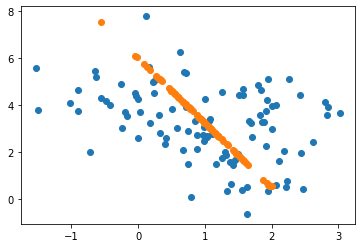

In [26]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X_hat[:, 0], X_hat[:, 1])

In [27]:
Encoder(1).apply({"params":params["params"]["encoder"]}, X)[:5]

DeviceArray([[3.1557117],
             [1.8389622],
             [2.6328232],
             [2.1354127],
             [1.5465757]], dtype=float32)

In [28]:
from sklearn import datasets

In [29]:
digits = datasets.load_digits()

In [30]:
X = jnp.array(digits['data'])
y = digits["target"]

In [31]:
X.shape

(1797, 64)

In [94]:
bn = 4
ae = AE(bn, X.shape[1])

ae

AE(
    # attributes
    bottleneck = 4
    out = 64
)

In [95]:
print(ae.tabulate(random.PRNGKey(0), X))



                                   AE Summary                                   
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path           ┃ module  ┃ inputs         ┃ outputs         ┃ params         ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│                │ AE      │ float32[1797,… │ float32[1797,6… │                │
├────────────────┼─────────┼────────────────┼─────────────────┼────────────────┤
│ encoder        │ Encoder │ float32[1797,… │ float32[1797,4] │                │
├────────────────┼─────────┼────────────────┼─────────────────┼────────────────┤
│ encoder/Dense… │ Dense   │ float32[1797,… │ float32[1797,5] │ bias:          │
│                │         │                │                 │ float32[5]     │
│                │         │                │                 │ kernel:        │
│                │         │                │                 │ float32[64,5]  │
│                │         

In [96]:
params = ae.init(random.PRNGKey(0), X)

In [97]:
jax.tree_util.tree_map(lambda x: x.shape, params)

FrozenDict({
    params: {
        decoder: {
            Dense_0: {
                bias: (5,),
                kernel: (4, 5),
            },
            Dense_1: {
                bias: (64,),
                kernel: (5, 64),
            },
        },
        encoder: {
            Dense_0: {
                bias: (5,),
                kernel: (64, 5),
            },
            Dense_1: {
                bias: (4,),
                kernel: (5, 4),
            },
        },
    },
})

In [98]:
import seaborn as sns
import pandas as pd
def plot_encoding_2dim(encoder, params):
    assert encoder.bottleneck >= 2
    X_low = encoder.apply({"params":params["params"]["encoder"]}, X)
    df = pd.DataFrame(X_low)
    df["label"] = y
    sns.pairplot(df, hue="label", palette="bright")

In [99]:
tx = optax.adam(learning_rate=1e-2)
params = ae.init(random.PRNGKey(0), X)
opt_state = tx.init(params)

### Untrained encodings

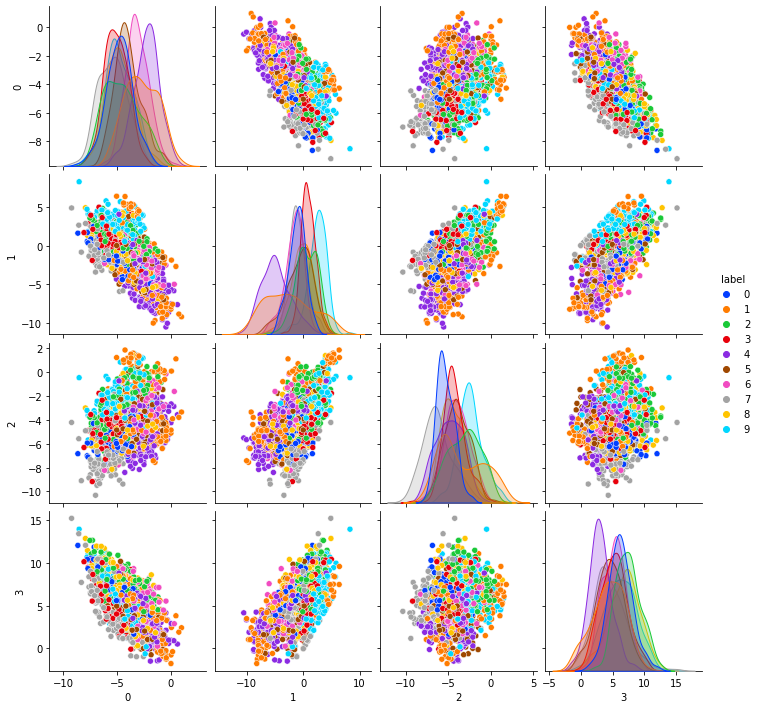

In [100]:
plot_encoding_2dim(Encoder(bottleneck=bn), params)

In [105]:
for i in range(2000):
    loss_val, grads = loss_grad_fn(params, X)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 100 == 0:
        print('Loss step {}: '.format(i), loss_val)

Loss step 0:  536.34247
Loss step 100:  533.9467
Loss step 200:  531.69714
Loss step 300:  529.68225
Loss step 400:  527.95624
Loss step 500:  526.3703
Loss step 600:  525.06116
Loss step 700:  523.9822
Loss step 800:  523.07874
Loss step 900:  522.33716
Loss step 1000:  521.7453
Loss step 1100:  521.40717
Loss step 1200:  520.6269
Loss step 1300:  520.1661
Loss step 1400:  519.82477
Loss step 1500:  519.55743
Loss step 1600:  518.9795
Loss step 1700:  518.58484
Loss step 1800:  518.24805
Loss step 1900:  518.06


### Trained encodings

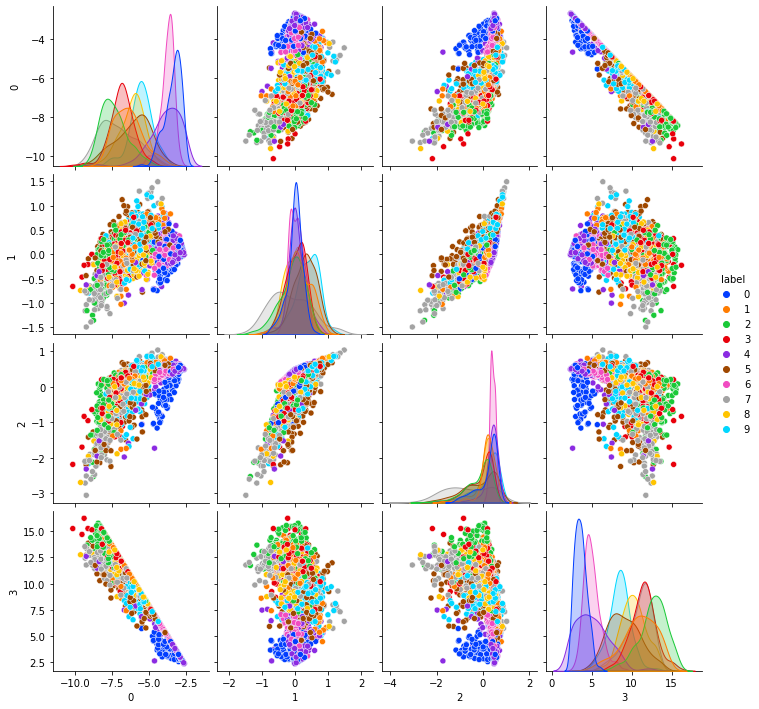

In [106]:
plot_encoding_2dim(Encoder(bottleneck=bn), params)

### Reconstruction

In [86]:
X_recon = ae.apply(params, X)

In [87]:
def plot_orig_recon(index=0):
    fig, ax = plt.subplots(sharex=True, ncols=2)
    ax[0].imshow(X[index].reshape(8, 8), cmap='Greys')
    ax[1].imshow(X_recon[index].reshape(8, 8), cmap='Greys')

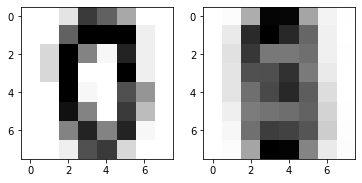

In [88]:
plot_orig_recon(20)